## Motivation

Given an asset’s historical prices over some time horizon (e.g., the price of APPL on each trading day of 2019), it is often of practical importance to fit a distribution to those prices.

One choice of parametric model for stock prices is [geometric Brownian motion](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) (GBM). This note derives maximum likelihood estimators for the parameters of a GBM.

A word of caution: a GBM is generally unsuitable for long periods. Other choices of models include a GBM with nonconstant drift and volatility, stochastic volatility models, a jump-diffusion to capture large price movements, or a non-parametric model altogether. Regardless of what choice is made, it is prudent to perform a [goodness of fit test](https://en.wikipedia.org/wiki/Goodness_of_fit) (outside of the scope of this note) a posteriori.

## Geometric Brownian motion

Consider an asset $S$ which follows geometric Brownian motion (GBM) with constant drift $\mu$ and volatility $\sigma$:
\begin{equation}
dS_{t}=\mu S_{t}dt+\sigma S_{t}dW_{t}.
\end{equation}
By [Ito's lemma](https://en.wikipedia.org/wiki/It%C3%B4%27s_lemma), $X_{t}=\log S_{t}$ satisfies
\begin{equation}
dX_{t}=\left(\mu-\frac{1}{2}\sigma^{2}\right)dt+\sigma dW_{t}.
\end{equation}
Suppose the asset's prices are observed at the sequence of (increasing) times $t_{0},t_{1},\ldots,t_{N}$.
By the previous paragraph,
\begin{equation}
\Delta X_{n}=\left(\mu-\frac{1}{2}\sigma^{2}\right)\Delta t_{n}+\sigma\Delta W_{n}
\end{equation}
where $\Delta X_{n}=X_{t_{n}}-X_{t_{n-1}}$, $\Delta t_{n}=t_{n}-t_{n-1}$, and $\Delta W_{n}=W_{t_{n}}-W_{t_{n-1}}$.
In particular, $\Delta X_{n}$ is normal with mean $(\mu-\frac{1}{2}\sigma^{2})\Delta t_{n}$ and variance $\sigma^{2}\Delta t_{n}$.

## Maximum likelihood estimation

Let $\delta X=X_{t_{N}}-X_{t_{0}}$ and $\delta t=t_{N}-t_{0}$ for brevity.
The main result is summarized below.

**Proposition.**
*The maximum likelihood estimators (MLE) of the drift and volatility are
\begin{equation}
\hat{\mu} =\frac{\delta X}{\delta t}+\frac{1}{2}\hat{\sigma}^{2}
\end{equation}
and
\begin{equation}
\hat{\sigma}^{2} =-\frac{1}{N}\frac{\left(\delta X\right)^{2}}{\delta t}+\frac{1}{N}\sum_{n=1}^{N}\frac{\Delta X_{n}^{2}}{\Delta t_{n}}.
\end{equation}
In the case of evenly spaced time intervals ($\Delta t_{n} = \delta t / N$), $\hat{\sigma}^{2}$ simplifies to
\begin{equation}
\hat{\sigma}^{2}=-\frac{1}{N}\frac{\left(\delta X\right)^{2}}{\delta t}+\frac{1}{\delta t}\sum_{n=1}^{N}\Delta X_{n}^{2}.
\end{equation}*

The derivation of the proposition is given in the final section of this note.

*Remark*.
If the exact value of the volatility is known a priori, the MLE $\hat{\mu}$ above can still be used by replacing $\hat{\sigma}$ with $\sigma$.
On the other hand, if the exact value of the drift is known a priori, the expression for $\hat{\sigma}$ above is not an MLE.
The appropriate expression in this case is given in the final section of this note.

## Estimating NASDAQ drift and volatility in 2017

In [1]:
%load_ext lab_black

In [3]:
import numpy as np
import yfinance as yf

ticker = yf.Ticker("^IXIC")  # NASDAQ
df = ticker.history(start="2017-01-01", end="2017-12-31")

price = (df.Open + df.Close) / 2.0
price = price.values

log_price = np.log(price)  # X
delta = log_price[1:] - log_price[:-1]  # ΔX
n_samples = delta.size  # N
n_years = 1.0  # δt
total_change = log_price[-1] - log_price[0]  # δX

vol2 = (-(total_change**2) / n_samples + np.sum(delta**2)) / n_years
# Equivalent but slower: `vol2 = np.var(delta) * delta.size / n_years`
vol = np.sqrt(vol2)

drift = total_change / n_years + 0.5 * vol2

print("drift: {0:06.3f}%".format(drift * 100))
print("vol:   {0:06.3f}%".format(vol * 100))

drift: 24.696%
vol:   07.530%


The true value of the NASDAQ along with 9 GBM simulations using the drift and volatility parameters above are shown below.

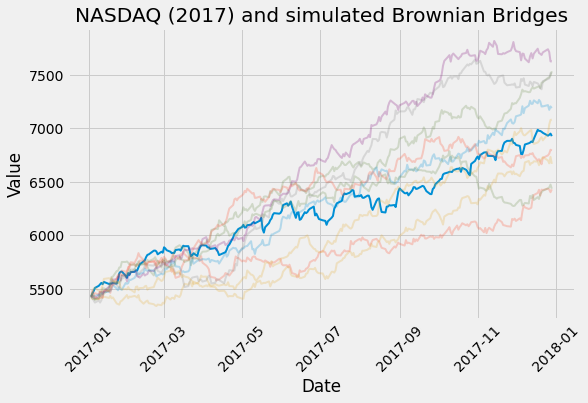

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt

n_days = 251
n_sims = 9
sims = np.empty([n_days, n_sims])
sims[0] = price[0]
dt = 1.0 / 250
for n in range(1, n_days):
    sims[n] = sims[n - 1] * (
        1.0 + drift * dt + vol * np.random.randn(n_sims) * np.sqrt(dt)
    )

mpl.style.use("fivethirtyeight")
mpl.rcParams["lines.linewidth"] = 2
plt.figure(figsize=(1.618 * 5.0, 5.0))
plt.plot(df.index, price)
for sim in sims.T:
    plt.plot(df.index, sim, alpha=0.25)
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Value")
_ = plt.title("NASDAQ (2017) and simulated Brownian Bridges")

## Derivation

The MLE are obtained by maximizing the log-likelihood
\begin{equation}
\ell=\sum_{n=1}^{N}\log f_{n}(\Delta X_{n})
\end{equation}
where $f_{n}$ is the density of $\Delta X_{n}$.
In particular,
\begin{equation}
\log f_{n}(\Delta X_{n})=-\ln(\sigma)-\frac{\left(\Delta X_{n}-\left(\mu-\frac{1}{2}\sigma^{2}\right)\Delta t_{n}\right)^{2}}{2\sigma^{2}\Delta t_{n}}+\text{const.}
\end{equation}
Some calculus reveals
\begin{equation}
\frac{\partial\log f_{n}(\Delta X_{n})}{\partial\mu}=\frac{\Delta X_{n}-\left(\mu-\frac{1}{2}\sigma^{2}\right)\Delta t_{n}}{\sigma^{2}}.
\end{equation}
Therefore,
\begin{equation}
\frac{\partial\ell}{\partial\mu}=\frac{\delta X-\left(\mu-\frac{1}{2}\sigma^{2}\right)\delta t}{\sigma^{2}}.
\end{equation}
Setting this to zero and solving for $\mu$ yields the MLE
\begin{equation}
\hat{\mu}=\frac{\delta X}{\delta t}+\frac{1}{2}\sigma^{2}.
\end{equation}
Similarly,
\begin{equation}
\frac{\partial\log f_{n}(\Delta X_{n})}{\partial\sigma}=\frac{\left(\mu^{2}-\frac{1}{4}\sigma^{4}\right)\Delta t_{n}-\sigma^{2}-2\mu\Delta X_{n}+\Delta X_{n}^{2}\Delta t_{n}^{-1}}{\sigma^{3}}.
\end{equation}
Therefore,
\begin{equation}
\frac{\partial\ell}{\partial\sigma}=\frac{\left(\mu^{2}-\frac{1}{4}\sigma^{4}\right)\delta t-N\sigma^{2}-2\mu\delta X+\sum_{n}\Delta X_{n}^{2}\Delta t_{n}^{-1}}{\sigma^{3}}.
\end{equation}
Setting the above to zero and solving for $\hat{\sigma}$ yields the MLE
\begin{equation}\label{eq:vol_mle}
\hat{\sigma}^{2}=2\frac{\sqrt{\delta t\left(\mu^{2}\delta t-2\mu\delta X+\sum_{n}\Delta X_{n}^{2}\Delta t_{n}^{-1}\right)+N^{2}}-N}{\delta t}.
\tag{1}
\end{equation}
If the exact value of drift is known a priori, \eqref{eq:vol_mle} is an MLE for the volatility.
Otherwise, evaluate $\hat{\mu}$ at $\sigma=\hat{\sigma}$ and replace $\mu$ in the above by the resulting expression.
Then, solving the for $\hat{\sigma}^2$ yields the remaining result of the proposition.